In [1]:
import time
start_time=time.time()

In [2]:
import cmasher as cmr
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import lmfit
import json
import astropy.units as u
import bfunc
import pandas as pd
import corner
from scipy import interpolate
import pickle
import bplot

Data load and region parameters

In [3]:
data = 'M8'

In [4]:
name = 'Lagoon'

In [5]:
pickle_in = open('Results//SF' + data + '.pkl',"rb")
SFresults = pickle.load(pickle_in)

In [6]:
#mask = SFresults['SF']["N pairs"] > 0

In [7]:
B = np.array(SFresults['b2'])#[mask]
r = np.array(SFresults['s'])#[mask]
pc =  SFresults['pc']
#pix =  SFresults['pix']
box_size =  SFresults['box_size']
pc_per_arcsec = pc
print("No pixels in this case")
print("Parsec per arcsec:", pc_per_arcsec)
print("Box size, parsec:", box_size)

No pixels in this case
Parsec per arcsec: 0.0060601710138692
Box size, parsec: 16.096436126419555


In [8]:
# Merge first K points
K = 1
r[K] = np.mean(r[:K])
B[K] = np.mean(B[:K])
r = r[K:]
B = B[K:]

Define some scales for turning points in sf

In [9]:
r_local_peak = 2.5
r_local_minimum = 4.5

Move the specification of which points to fit to be before the setting of the parameter limits.

In [10]:
relative_uncertainty = 0.15
weights = 1.0 / (relative_uncertainty * B)
large_scale = r > 0.5 * box_size
# Define large-scale differently in this case
#weights[r > 0.5 * r_local_peak] /= 2.0

In [11]:
to_fit = r <= r_local_minimum

In [12]:
model = lmfit.Model(bfunc.bfunc04s)
model.param_names

['r0', 'sig2', 'm', 's0', 'noise', 'box_size']

Use only the points we will be fitting when determining the limits on `sig2`

In [13]:
# Correlation length between 1/10 and 2 x box_size
model.set_param_hint("r0", value=0.1 * box_size, min=0.01 * box_size, max=2 * box_size)

# sig2 between 1/10 and 2 x max value of B(r)
model.set_param_hint(
    "sig2", 
    value=0.5 * B[to_fit].max(), 
    min=0.1 * B[to_fit].max(), 
    max=2 * B[to_fit].max())

# m between 1/2 and 5/3
model.set_param_hint("m", value=1.0, min=0.5, max=2.0)

# Seeing RMS between 0.1 and 1.5 arcsec
model.set_param_hint("s0", value=0.5 * pc_per_arcsec, min=0.1 * pc_per_arcsec, max=1.5 * pc_per_arcsec)

# Noise cannot be much larger than smallest B(r)
model.set_param_hint("noise", value=0.2 * B.min(), min=0.0, max=3 * B.min())

# box_size is fixed
model.set_param_hint("box_size", value=box_size, vary=False)

In [14]:
pd.DataFrame(model.param_hints)

,r0,sig2,m,s0,noise,box_size
value,1.609644,7.229295,1.0,0.003030,0.081954,16.096436
min,0.160964,1.445859,0.5,0.000606,0.000000,NaN
max,32.192872,28.917181,2.0,0.009090,1.229315,NaN
vary,NaN,NaN,NaN,NaN,NaN,False


In [15]:
result = model.fit(B[to_fit], weights=weights[to_fit], r=r[to_fit])

In [16]:
result

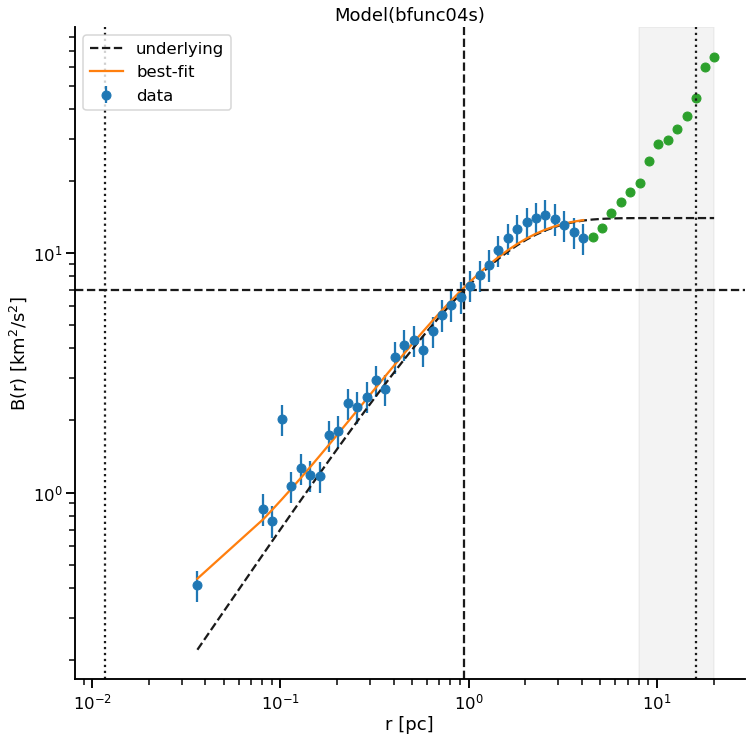

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the underlying model without instrumental effects
Bu = bfunc.bfunc00s(r, result.params["r0"].value, result.params["sig2"].value, result.params["m"].value)
ax.plot(r, Bu, color="k", linestyle="dashed", label="underlying")

# Plot the fit results
result.plot_fit(ax=ax)

# Add in the points not included in fit
ax.plot(r[~to_fit], B[~to_fit], "o")

# Dotted lines for 2 x rms seeing and for box size
ax.axvline(2 * result.params["s0"].value, color="k", linestyle="dotted")
ax.axvline(result.params["box_size"].value, color="k", linestyle="dotted")

# Dashed lines for best-fit r0 and sig2
ax.axvline(result.params["r0"].value, color="k", linestyle="dashed")
ax.axhline(result.params["sig2"].value, color="k", linestyle="dashed")

# Gray box to indicate the large scale values that are excluded from the fit
ax.axvspan(result.params["box_size"].value / 2, r[-1], color="k", alpha=0.05, zorder=-1)

ax.set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
)
sns.despine();

emcee

In [18]:
emcee_kws = dict(steps=10000, burn=1000, thin=50, is_weighted=True,
                 progress=False, workers=16)
emcee_params = result.params.copy()
# emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

In [19]:
result_emcee = model.fit(
    data=B[to_fit], r=r[to_fit], weights=weights[to_fit], params=emcee_params, method='emcee',
    nan_policy='omit', fit_kws=emcee_kws,
)

In [20]:
result_emcee

Text(0, 0.5, 'acceptance fraction')

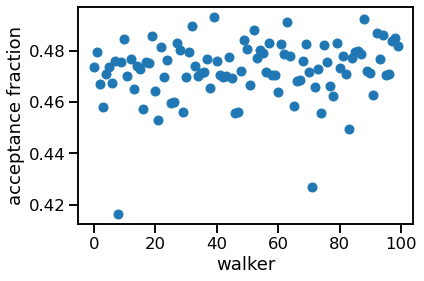

In [21]:
plt.plot(result_emcee.acceptance_fraction, 'o')
plt.xlabel('walker')
plt.ylabel('acceptance fraction')

In [22]:
if hasattr(result_emcee, "acor"):
    print("Autocorrelation time for the parameters:")
    print("----------------------------------------")
    for i, p in enumerate(result_emcee.params):
        try:
            print(f'{p} = {result_emcee.acor[i]:.3f}')
        except IndexError:
            pass

Autocorrelation time for the parameters:
----------------------------------------
r0 = 163.195
sig2 = 152.184
m = 120.748
s0 = 82.093
noise = 92.136


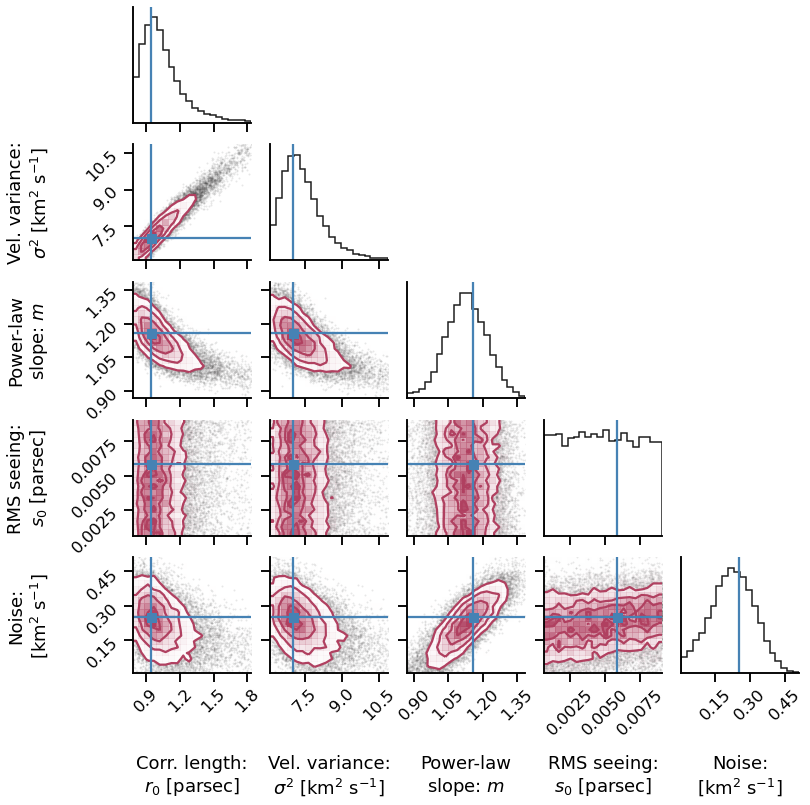

In [23]:
bplot.corner_plot(result_emcee, result, name, data, 
                  data_ranges=[0.95, 0.95, 0.995, 0.999, 0.999]);
#data_ranges=[0.95, 0.99, 0.995, 0.995, 0.999]

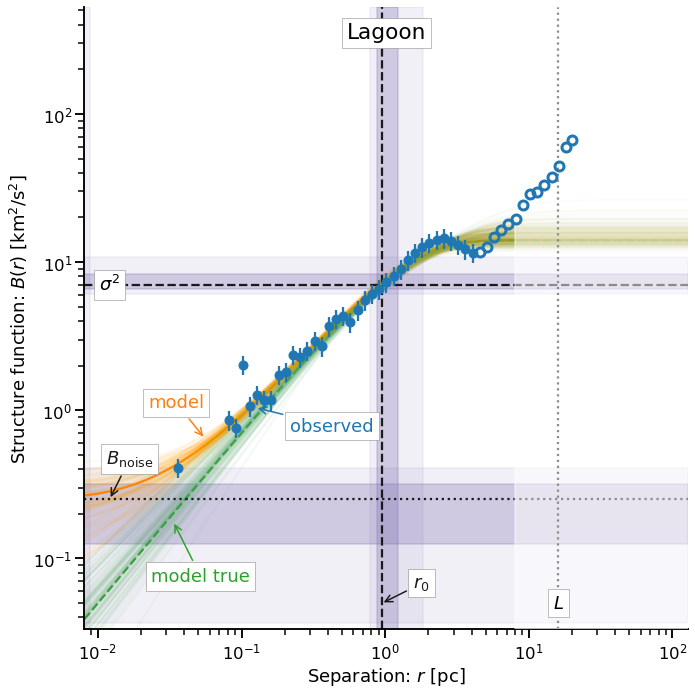

In [24]:
bplot.STYLE["data label element"] = 4
bplot.STYLE["model label element"] = 0
bplot.STYLE["model label offset"] = (-60, 40)
bplot.STYLE["true model label element"] = 7
bplot.STYLE["true model label offset"] = (30, -60)
bplot.strucfunc_plot(result_emcee, result, r, B, to_fit, name, data, box_size, large_scale)

In [25]:
CIresults = {'result_emcee': result_emcee,
            'result' : result
          }

In [26]:
f = open('Results//CI' + data +'.pkl',"wb")
pickle.dump(CIresults,f)
f.close()

In [27]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 105.1384630203247 seconds ---
